In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys

In [2]:
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_opt_all_comparison_test_results.csv") 

#results = pd.concat([results, results2], ignore_index=True)
#results = results.rename(columns={"Average": "Mean"})

In [3]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 154
Correct Results: 154


In [4]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [5]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [6]:
def make_compare_graph(title, df, order, color, hatching, filename, x_value='Query Number', y_value='Mean'):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x=x_value, y=y_value, hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, -0.1),
              ncol=5, fancybox=True, shadow=True)
    
    ax.set_title(title)

    if filename != None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [11]:
results[results["Query Number"] == 14]

,Query Type,Query Number,Mean,Runs
95,"O1,O2,O3 SDQLpy",14,0.214456,"[0.21660685539245605, 0.22284603118896484, 0.2..."
96,"O1,O2,O3,O4 SDQLpy",14,0.235425,"[0.2272639274597168, 0.23552227020263672, 0.23..."
97,Pandas Converted (Hyper DB),14,0.158186,"[0.1591956615447998, 0.1570281982421875, 0.156..."
94,"O1,O2 SDQLpy",14,0.305272,"[0.308347225189209, 0.3032653331756592, 0.3078..."
92,Naive SDQLpy,14,0.114008,"[0.13196825981140137, 0.10314559936523438, 0.1..."
91,Hyper DB,14,0.220347,"[0.25397682189941406, 0.22121214866638184, 0.2..."
93,O1 SDQLpy,14,0.323669,"[0.325106143951416, 0.31877660751342773, 0.327..."


## Statistics

In [7]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", g_mean)
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})

overall.head(10)

,Overall Mean Runtime (s)
Query Type,
"O1,O2,O3,O4 SDQLpy",0.170093
"O1,O2,O3 SDQLpy",0.189468
"O1,O2 SDQLpy",0.202112
O1 SDQLpy,0.205774
Hyper DB,0.366398
Naive SDQLpy,0.369673
Pandas Converted (Hyper DB),0.524752


In [9]:
# Should be: (OLD, NEW)
relevant_pairs = [
    ("Hyper DB", "O1,O2,O3,O4 SDQLpy"),
    ("Hyper DB", "O1 SDQLpy"),
    ("Naive SDQLpy", "O1,O2,O3,O4 SDQLpy")
]

def get_from_df_by_index(index_value):
    return float(overall.loc[[index_value]]["Overall Mean Runtime (s)"].iloc[0])

def percentage_reduction_in_time(old_time, new_time):
    return round(((old_time - new_time) / old_time) * 100, 2)

for old, new in relevant_pairs:
    old_value = get_from_df_by_index(old)
    new_value = get_from_df_by_index(new)
    print(f"From {old} to {new}, there was a {percentage_reduction_in_time(old_value, new_value)}% reduction in runtime")

From Hyper DB to O1,O2,O3,O4 SDQLpy, there was a 53.58% reduction in runtime
From Hyper DB to O1 SDQLpy, there was a 43.84% reduction in runtime
From Naive SDQLpy to O1,O2,O3,O4 SDQLpy, there was a 53.99% reduction in runtime


## Speedup Graph


In [40]:
overall

,Overall Mean Runtime (s)
Query Type,
"O1,O2,O3,O4 SDQLpy",0.170093
"O1,O2,O3 SDQLpy",0.189468
"O1,O2 SDQLpy",0.202112
O1 SDQLpy,0.205774
Hyper DB,0.366398
Naive SDQLpy,0.369673
Pandas Converted (Hyper DB),0.524752


In [43]:
speedup = overall.reset_index()
speedup['Query Type'] = speedup['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas',
        'O1,O2 SDQLpy': 'O1-O2 SDQLpy',
        'O1,O2,O3 SDQLpy': 'O1-O3 SDQLpy',
        'O1,O2,O3,O4 SDQLpy': 'O1-O4 SDQLpy',
     }
)
# Against HyperDB
hyper_runtime = float(speedup[speedup["Query Type"] == "Hyper DB"]["Overall Mean Runtime (s)"])

order = ['Pandas', 'Naive SDQLpy', 'O1 SDQLpy', 'O1-O2 SDQLpy', 'O1-O3 SDQLpy', 'O1-O4 SDQLpy', 'Hyper DB']

speedup = speedup.set_index('Query Type').loc[order]
speedup = speedup.reset_index()

speedup["Overall Mean Runtime (s)"] = speedup["Overall Mean Runtime (s)"].apply(lambda x: hyper_runtime/x)

speedup

/tmp/ipykernel_336438/4287883368.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hyper_runtime = float(speedup[speedup["Query Type"] == "Hyper DB"]["Overall Mean Runtime (s)"])


,Query Type,Overall Mean Runtime (s)
0,Pandas,0.698230
1,Naive SDQLpy,0.991139
2,O1 SDQLpy,1.780584
3,O1-O2 SDQLpy,1.812845
4,O1-O3 SDQLpy,1.933824
5,O1-O4 SDQLpy,2.154102
6,Hyper DB,1.000000


<Figure size 640x480 with 0 Axes>

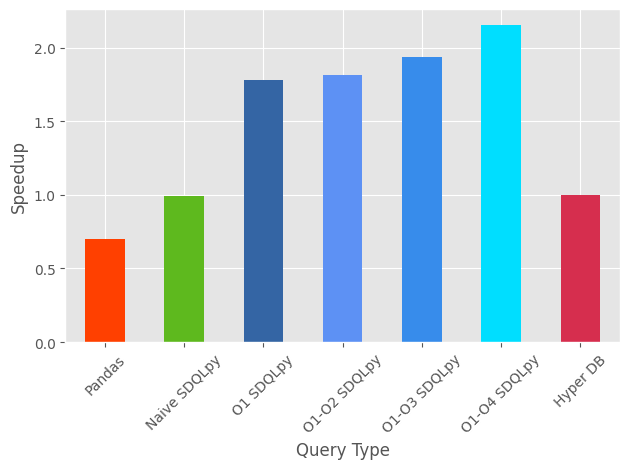

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure()

colours = ['#ff4000', '#5eb91e', '#3465a4', '#5d91f4', '#378ceb', '#00deff', '#d62e4e']
ax = speedup.plot(kind='bar', x='Query Type', y='Overall Mean Runtime (s)', rot=45, color=colours)
ax.get_legend().remove()
ax.set_ylabel("Speedup")
plt.tight_layout()
plt.savefig("speedup.png")